## Import Dependencies

In [94]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
  
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

[nltk_data] Downloading package wordnet to /Users/home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/home/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Importing the dataset

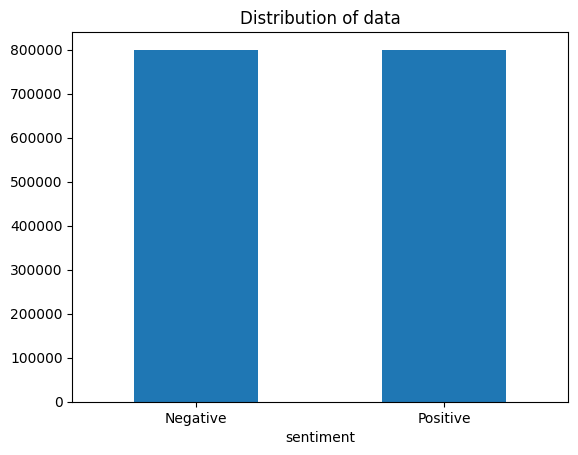

In [95]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('./input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## Preprocess Text

In [168]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [169]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [170]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 52 seconds


## Splitting the Data

In [171]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## TF-IDF Vectoriser

In [173]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Transforming the dataset

In [174]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## Creating & Evaluating Model Baselines

### Plot Metrics Score

### Precision-Recall Curve for Logistic Regression

In [175]:
def PRC(lg, x_train, y_train):
    y_scores_lg = lg.predict_proba(x_train) # predict_proba gives the probability of each observation belonging to each class
    
    precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_train, y_scores_lg[:, 1])
    
    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize = (10, 7))
    
    plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label = 'precision')
    
    plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')
    
    plt.xlabel('Threshold')
    
    plt.legend(loc = 'upper left')
    
    plt.ylim([0, 1])
    
    plt.show()

### Metrics Score Function
Used to evaluate the baseline of the model.

In [176]:
def baseline_metrics_score(model, X_train, y_train):
    predicted = model.predict(X_train)
    actual = y_train

   # Print the evaluation metrics for the dataset.
    print(classification_report(actual, predicted))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(actual, predicted)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Evaluate Model Function
Evaluates the model performance using test data.

In [177]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Evaluate Baseline of Tuned Model with Threshold

In [187]:
def optimal_threshold_baseline_metrics_score(model, X_train, y_train, optimal_threshold):
    predicted = model.predict_proba(X_train)
    actual = y_train
    # Print the evaluation metrics for the dataset.
    print(classification_report(actual, predicted[:,1] > optimal_threshold))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(actual, predicted[:,1] > optimal_threshold)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


### Evaluate Tuned Model with Threshold

In [179]:
def optimal_threshold_model_Evaluation(model, X_test, y_test, optimal_threshold):
    predicted = model.predict_proba(X_test)
    actual = y_test

    # Print the evaluation metrics for the dataset.
    print(classification_report(actual, predicted[:,1] > optimal_threshold))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(actual, predicted[:,1] > optimal_threshold)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### BernoulliNB Model

In [77]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)

BernoulliNB(alpha=2)

#### Evaluate Model Baseline Performance From Training Data

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    760011
           1       0.82      0.83      0.83    759989

    accuracy                           0.83   1520000
   macro avg       0.83      0.83      0.83   1520000
weighted avg       0.83      0.83      0.83   1520000



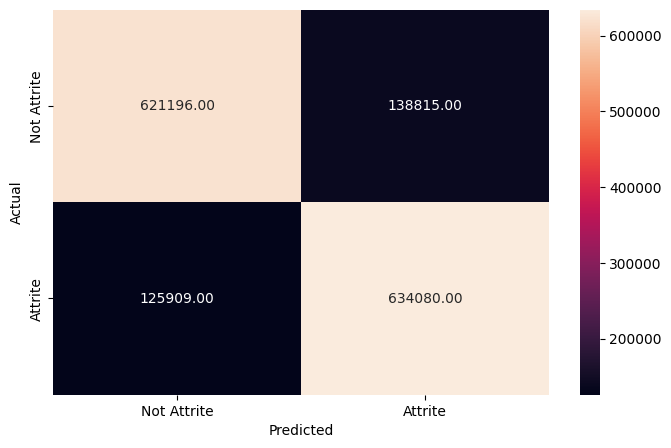

In [80]:
baseline_metrics_score(BNBmodel, X_train, y_train)

#### Test

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



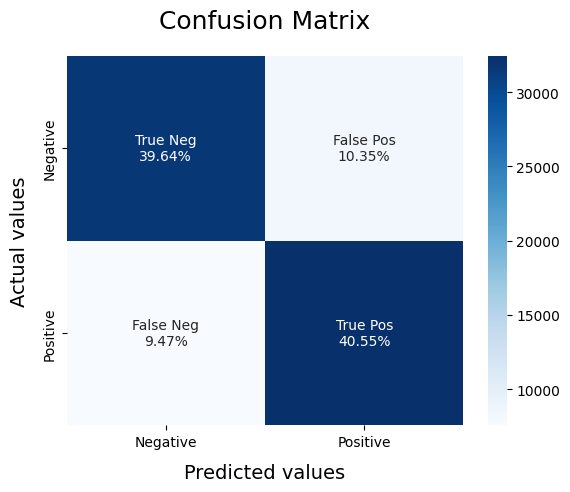

In [81]:
model_Evaluate(BNBmodel)

### Linear Support Vector Classification (LinearSVC)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



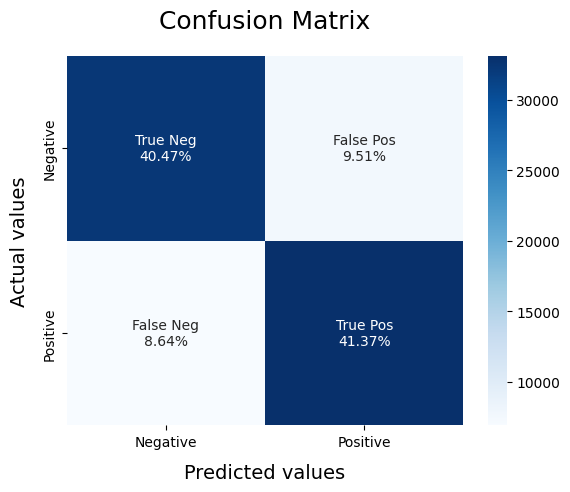

In [24]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

#### Evaluate Model Performance Based on Training data

              precision    recall  f1-score   support

           0       0.91      0.90      0.90    760011
           1       0.90      0.91      0.90    759989

    accuracy                           0.90   1520000
   macro avg       0.90      0.90      0.90   1520000
weighted avg       0.90      0.90      0.90   1520000



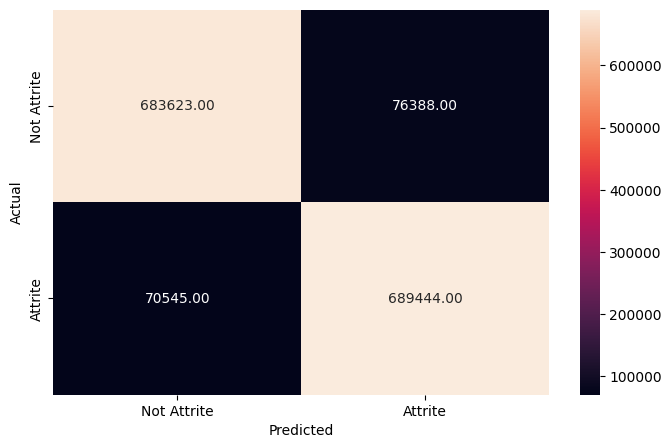

In [82]:
baseline_metrics_score(SVCmodel, X_train, y_train)

#### Test

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



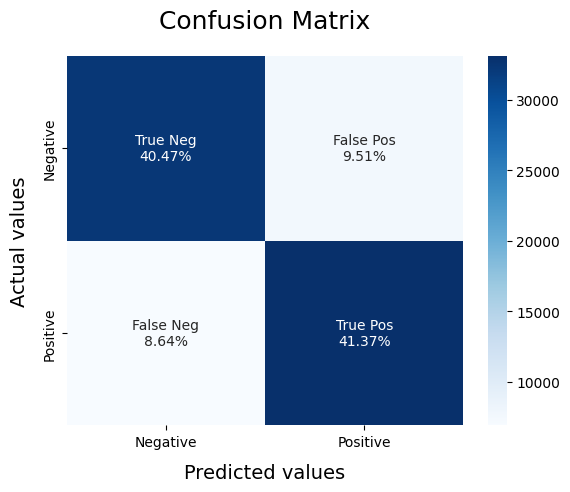

In [83]:
model_Evaluate(SVCmodel)

### Logistic Regression (LR)

In [180]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

#### Baseline Performance Based on the training data

              precision    recall  f1-score   support

           0       0.87      0.86      0.87    760011
           1       0.86      0.88      0.87    759989

    accuracy                           0.87   1520000
   macro avg       0.87      0.87      0.87   1520000
weighted avg       0.87      0.87      0.87   1520000



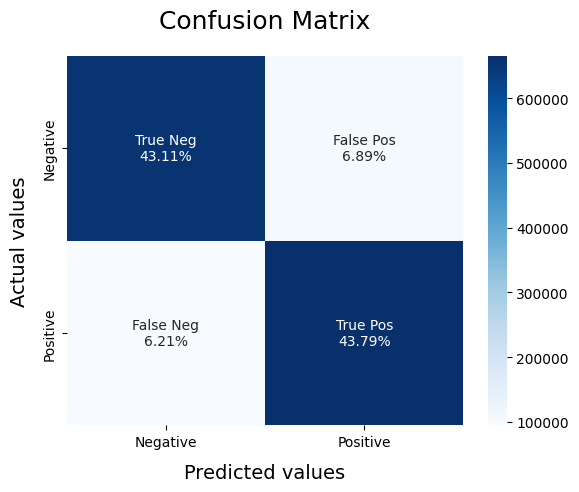

In [181]:
# Checking the performance on the training data (potential possible performance)
baseline_metrics_score(LRmodel, X_train, y_train)

#### Test
Model performance using test data

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



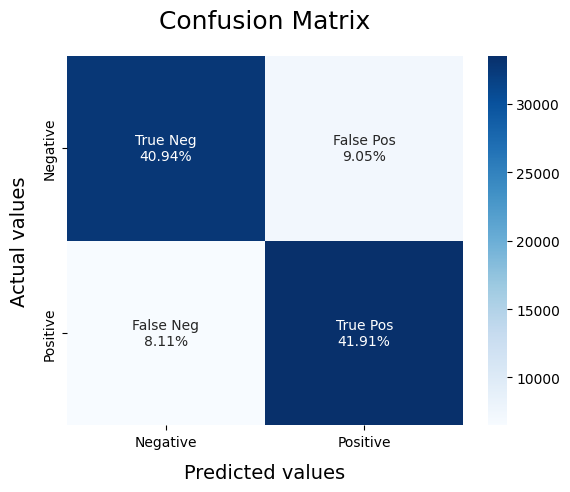

In [182]:
model_Evaluate(LRmodel)

#### Tuning

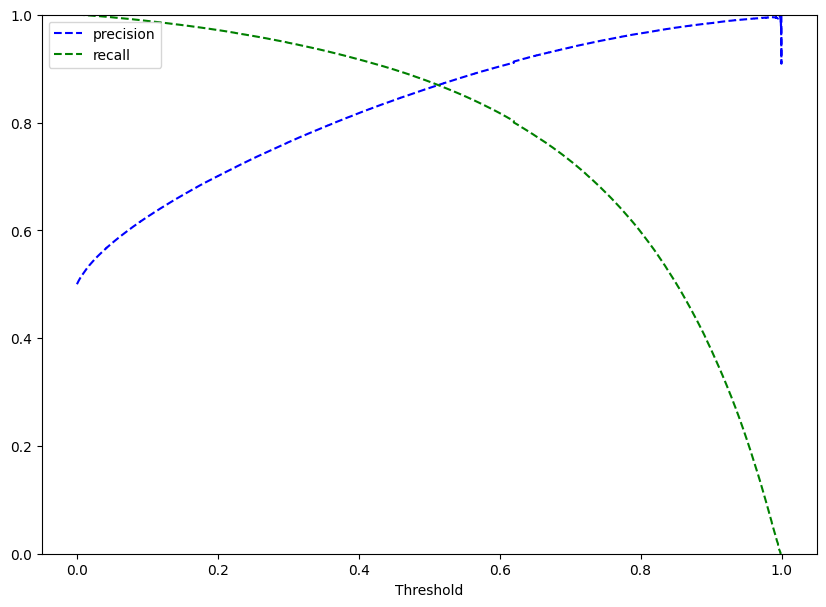

In [183]:
PRC(LRmodel, X_train, y_train)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87    760011
           1       0.89      0.85      0.87    759989

    accuracy                           0.87   1520000
   macro avg       0.87      0.87      0.87   1520000
weighted avg       0.87      0.87      0.87   1520000



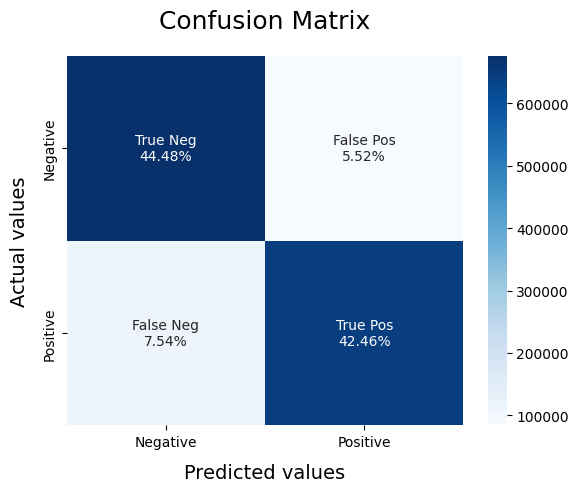

In [192]:
optimal_threshold_baseline_metrics_score(LRmodel,X_train,y_train,.55)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83     39989
           1       0.84      0.81      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



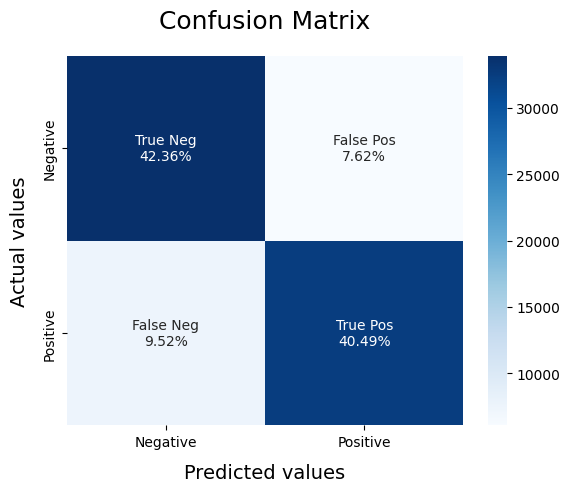

In [193]:
optimal_threshold_model_Evaluation(LRmodel,X_test,y_test,.55)

## Saving the Models

In [26]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

## Using the Model

In [210]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter.",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good",
            "I love you 3000",
            "God is like feeling a hand on your heart."]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                        text sentiment
0                            I hate twitter.  Negative
1                 May the Force be with you.  Positive
2            Mr. Stark, I don't feel so good  Negative
3                            I love you 3000  Positive
4  God is like feeling a hand on your heart.  Positive
